<a href="https://colab.research.google.com/github/uol-mediaprocessing-2021-2022/students_projects-can-i-read-it/blob/develop/can%2BI%2Bread%2Bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Output to colab (Quelle: Folien)
import matplotlib
%matplotlib inline

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

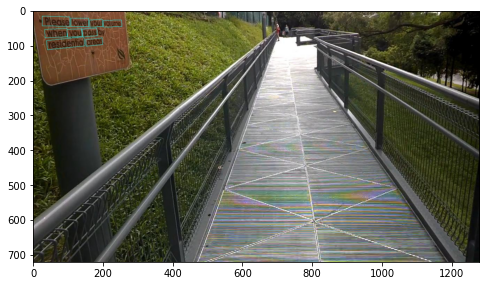

In [24]:
# Set image
img = cv.imread('drive/MyDrive/img_10.png')
     # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Create a list to store all preprocessed versions
preprocessed_list = []

# Add the original image to the list
preprocessed_list.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))

plt.figure(figsize=(8, 8))
plt.imshow(preprocessed_list[0])

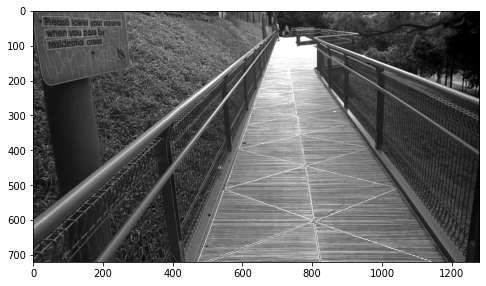

In [25]:
# Create a greyscale copy
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Output image
fig = plt.figure(figsize=(8,8))
plt.imshow(img_gray, cmap = "gray")

# Add greyscale copy to preprocessed List
img_gray = cv.merge((img_gray,img_gray,img_gray)) # Hack for 3 gray channels
preprocessed_list.append(img_gray)

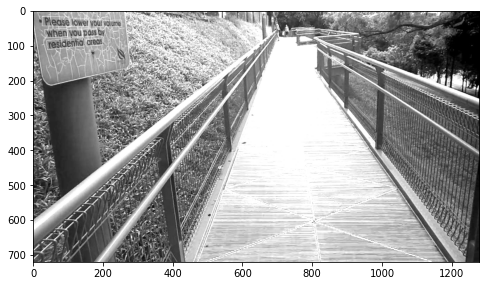

In [29]:
alpha = 2 # Contrast
beta = 0 # Brightness

# Change contrast (grayscale)
img_gray_highK = cv.convertScaleAbs(img_gray, alpha=alpha, beta=beta)

# Show plot
plt.figure(figsize=(8,8))
plt.imshow(img_gray_highK, cmap='gray')

# Add high contrast greyscale copy to preprocessed list
preprocessed_list.append(img_gray_highK)

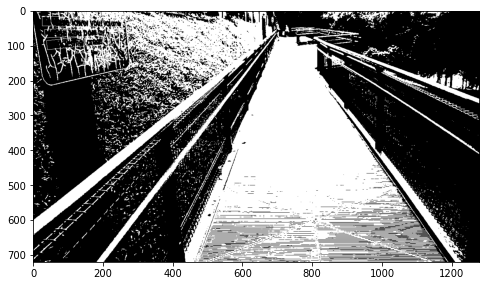

In [27]:
# Create a binary copy using thresholding
ret, img_bin = cv.threshold(img_gray,85,255,cv.THRESH_BINARY) 

# Output image
fig = plt.figure(figsize=(8,8))
plt.imshow(img_bin, cmap = "gray")

# Add binary copy to preprocessed List
#img_bin = cv.merge((img_bin,img_bin,img_bin)) # Hack for 3 binary channels
preprocessed_list.append(img_bin)

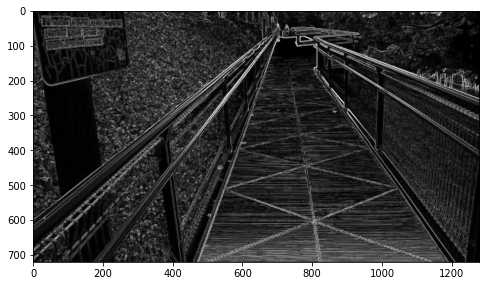

In [28]:
# Apply edge-detection using sobel filter on the grayscale picture

scale = 1
delta = 0
ddepth = cv.CV_16S
# Reduce noise using gaussian blur
src = cv.GaussianBlur(img, (3, 3), 0)
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
grad_x = cv.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
# Gradient-Y
# grad_y = cv.Scharr(gray,ddepth,0,1)
grad_y = cv.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    
abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)
    
grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

grad = cv.merge((grad, grad, grad)) # Hack for 3 gray channels

preprocessed_list.append(grad)

fig = plt.figure(figsize=(8,8))
plt.imshow(grad, cmap = "gray")

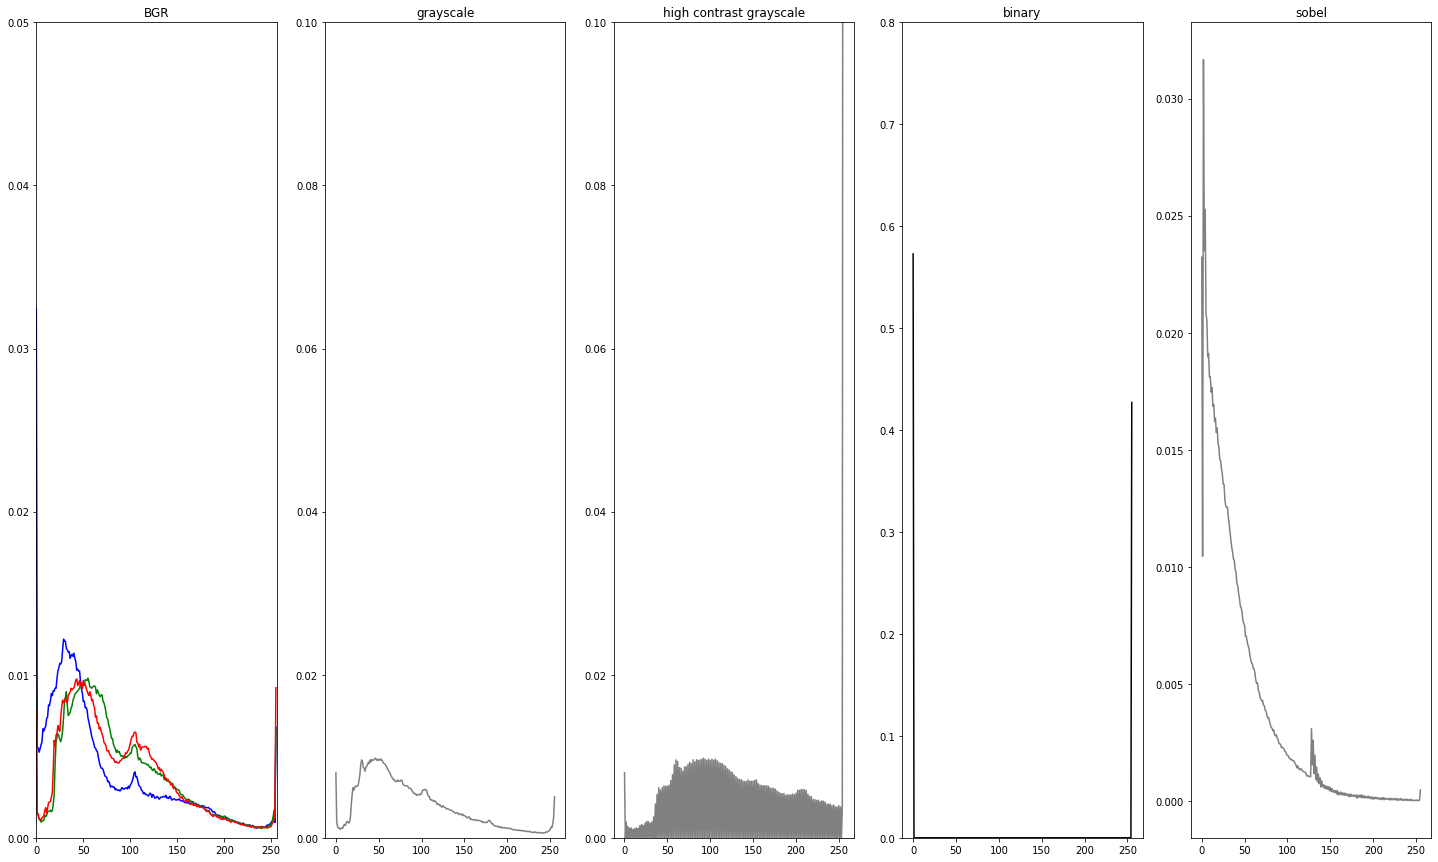

In [39]:
# plot histograms for the pictures in the processing list
histsize = 256
histrange = [0, histsize]

fig = plt.figure(figsize=(25, 15)) 
# histogram for BGR
ax1 = fig.add_subplot(1, len(preprocessed_list), 1)
ax1.title.set_text('BGR')
bgr_planes = cv.split(img)

hist_b = cv.calcHist([bgr_planes[0]],[0],None,[histsize],histrange)
hist_b = hist_b / hist_b.sum()
hist_g = cv.calcHist([bgr_planes[1]],[0],None,[histsize],histrange)
hist_g = hist_g / hist_g.sum()
hist_r = cv.calcHist([bgr_planes[2]],[0],None,[histsize],histrange)
hist_r = hist_r / hist_r.sum()
plt.xlim([0, 256])
plt.ylim([0,0.05])
plt.plot(hist_b,'b')
plt.plot(hist_g,'g')
plt.plot(hist_r,'r')

# histogram for grayscale
ax2 = fig.add_subplot(1, len(preprocessed_list), 2)
hist_gray = cv.calcHist([img_gray],[0],None,[histsize],histrange)
hist_gray = hist_gray / hist_gray.sum()
ax2.title.set_text('grayscale')
plt.ylim([0,0.1])
plt.plot(hist_gray,'gray')

# histogram for grayscale high contrast
ax3 = fig.add_subplot(1, len(preprocessed_list), 3)
hist_gray_hc = cv.calcHist([img_gray_highK],[0],None,[histsize],histrange)
hist_gray_hc  = hist_gray_hc / hist_gray_hc.sum()
ax3.title.set_text('high contrast grayscale')
plt.ylim([0,0.1])
plt.plot(hist_gray_hc,'gray')

# histogram for binary
ax4 = fig.add_subplot(1, len(preprocessed_list), 4)
hist_bin = cv.calcHist([img_bin],[0],None,[histsize],histrange)
hist_bin = hist_bin / hist_bin.sum()
ax4.title.set_text('binary')
plt.ylim([0,0.8])
plt.plot(hist_bin,'black') 

# histogram for sobel
ax5 = fig.add_subplot(1, len(preprocessed_list), 5)
hist_grad = cv.calcHist([grad],[0],None,[histsize],histrange)
hist_grad = hist_grad / hist_grad.sum()
ax5.title.set_text('sobel')
plt.plot(hist_grad, 'gray')

In [32]:
print(len(preprocessed_list))

5


[INFO] Initializing text detection with EAST [1/5]
[INFO] text detection took 8.972542 seconds
[INFO] Initializing text detection with EAST [2/5]
[INFO] text detection took 8.791506 seconds
[INFO] Initializing text detection with EAST [3/5]
[INFO] text detection took 8.820912 seconds
[INFO] Initializing text detection with EAST [4/5]
[INFO] text detection took 8.774450 seconds
[INFO] Initializing text detection with EAST [5/5]
[INFO] text detection took 8.784632 seconds


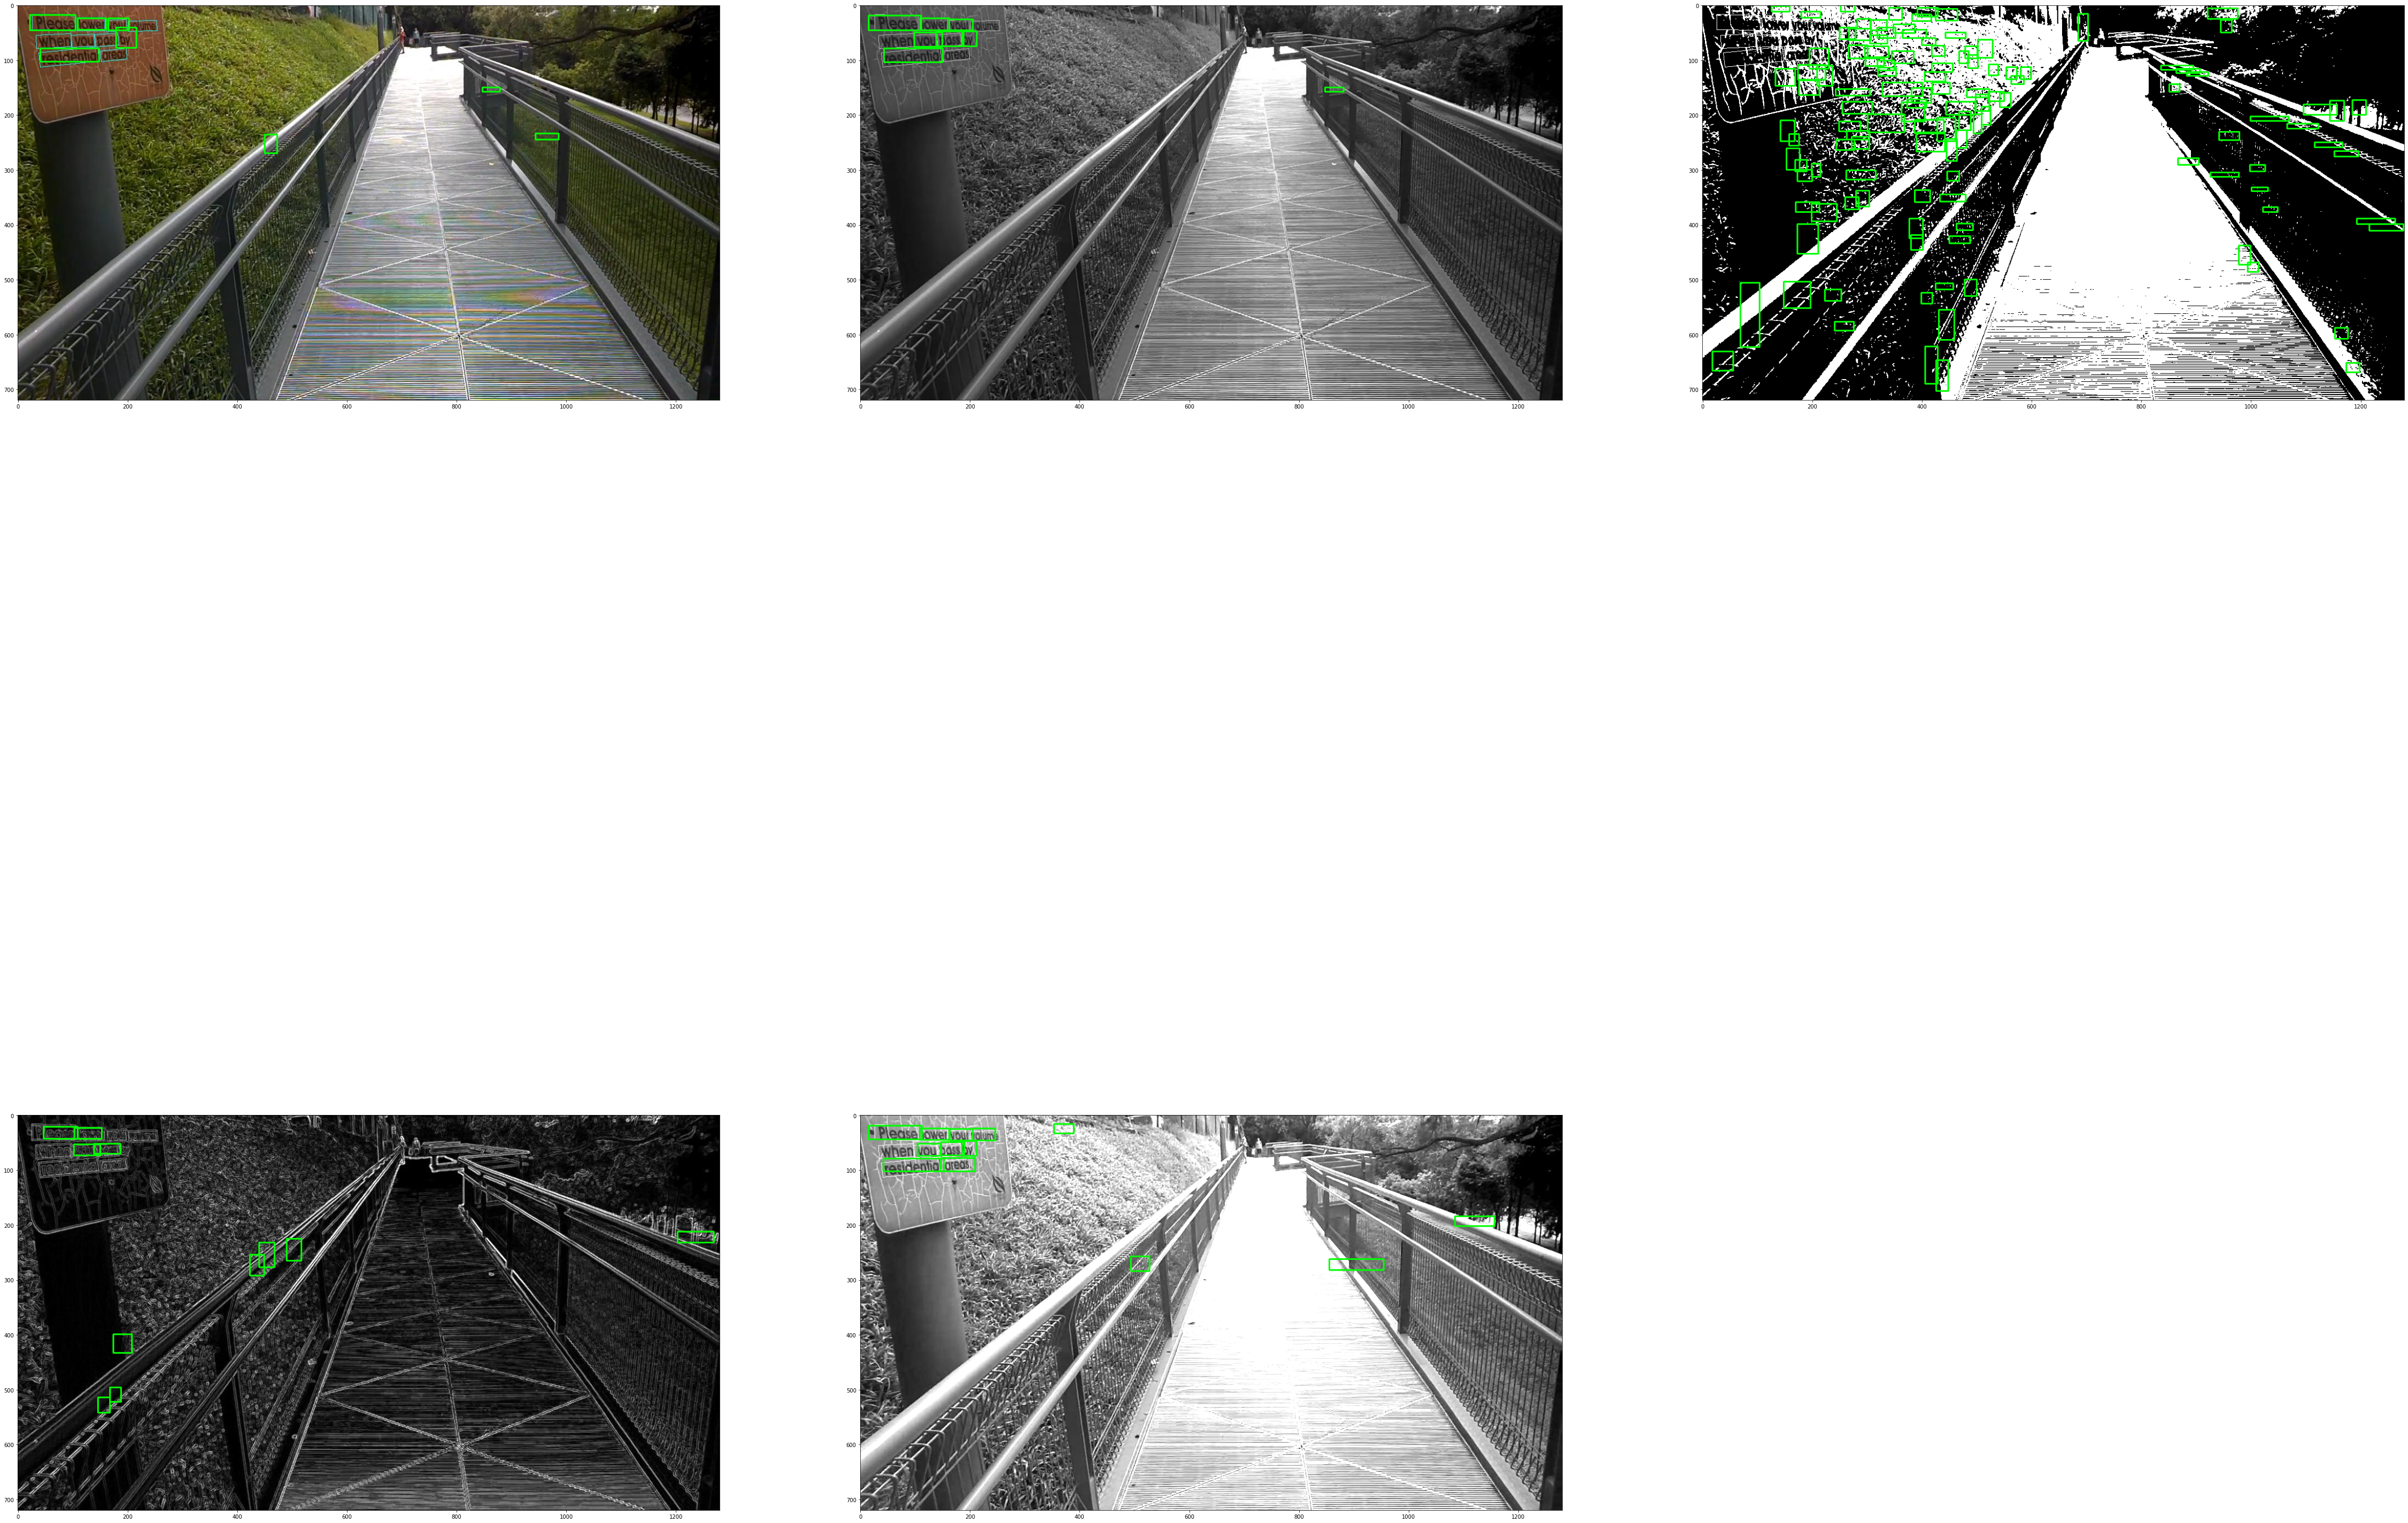

In [33]:
# Use EAST 
from imutils.object_detection import non_max_suppression
import time

# Create list that will contain cordinates of found text boxes for each images
boxes_list = []

# Set min confidence for text detection
min_score = 0.55 # Adjustable

# Set scaling resolution
res = 1280 # 1280x1280 works good, higher better, but slower


# Figure containing output images
fig = plt.figure(figsize=(80,70))

for index, preprocessed_img in enumerate(preprocessed_list):
	# Create copy and grab image dimensions
	orig = preprocessed_img.copy()
	orig_rectangles = preprocessed_img.copy()
	(H, W) = orig.shape[:2]

	# Adjust image dimensions (have to be multiples of 32 for EAST)
	(newW, newH) = (res, res)
	rW = W / float(newW)
	rH = H / float(newH)

	preprocessed_img = cv.resize(preprocessed_img, (newW, newH))
	(H, W) = preprocessed_img.shape[:2]

	# 2 layers are needed, the confiidences of the predictions and koordinates of found Text
	layerNames = [
		"feature_fusion/Conv_7/Sigmoid",
		"feature_fusion/concat_3"]

	# Load EAST
	print("[INFO] Initializing text detection with EAST [" + str(index + 1) + "/" + str(len(preprocessed_list)) + "]")
	net = cv.dnn.readNet('drive/MyDrive/east/frozen_east_text_detection.pb')

	# Create a "blob" and generate output using the trained model
	blob = cv.dnn.blobFromImage(preprocessed_img, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
	start = time.time()
	net.setInput(blob)
	(scores, geometry) = net.forward(layerNames)
	end = time.time()

	print("[INFO] text detection took {:.6f} seconds".format(end - start))
 
	# Grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# Iterate the rows
	for y in range(0, numRows):
		# Extract the scores alongside the cordinates of found text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# Iterate columns
		for x in range(0, numCols):
			# Ignore scores below the threshold
			if scoresData[x] < min_score:
				continue
			# Calculate offset factor as our resulting feature maps will
			# be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			# Calculate rotation angle
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# Calculate width and height of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			# Caclulate cordinates of the bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			# Add the bounding box coordinates and probability score to
			# our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
		
	# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
	boxes = non_max_suppression(np.array(rects), probs=confidences)

	# Iterate all boxes of an image
	for (startX, startY, endX, endY) in boxes:
		# Rescale the boxes
		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		# Draw boxes in output image
		cv.rectangle(orig_rectangles, (startX, startY), (endX, endY), (0, 255, 0), 2)

	# Add boxes to list containing all boxes for an image
	boxes_list.append(boxes)

	# Add output image to plot
	fig.add_subplot(2, 3, index+1)
	plt.imshow(orig_rectangles, cmap='gray')

# Display plot
plt.show()

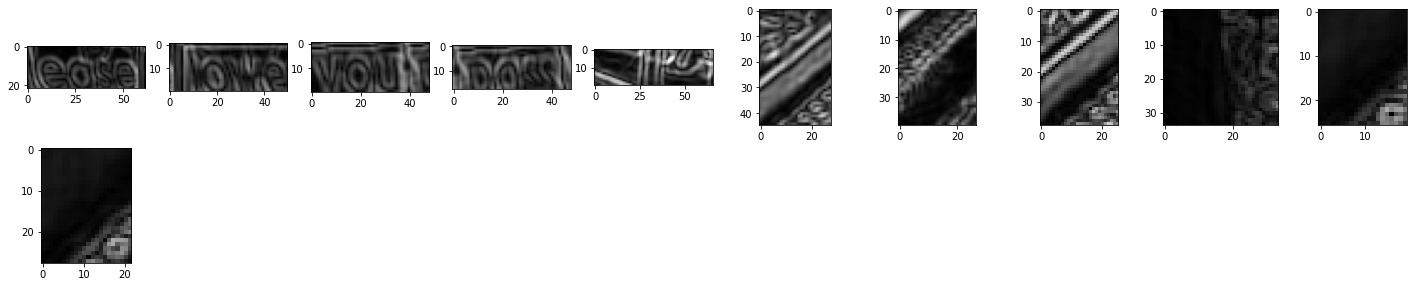

In [37]:
img_index = 3 # Set target index

# Create figure that will contain all cropped text areas (boxes)
fig = plt.figure(figsize=(25, 25))

def get_center(box):
    center_y = (box[1] + box[3]) / 2
    return int(center_y)

# Sort each boxes array
sorted_boxes = []

rect_list = boxes_list[img_index].tolist()
rect_list = sorted(rect_list, key=lambda k: [k[1], k[0]])

curr_startY = int(rect_list[0][1])
curr_endY  = int(rect_list[0][3])
y_range = range(curr_startY, curr_endY)
row = []

while(len(rect_list) > 0):

  curr_startY = int(rect_list[0][1])
  curr_endY  = int(rect_list[0][3])
  y_range = range(curr_startY-5, curr_endY+5)

  for rect in rect_list: 
    if len(rect_list) > 0:
      if get_center(rect) in y_range:
        row.append(rect)
  rect_list = [i for i in rect_list if i not in row]

  rect_list = sorted(rect_list, key=lambda k: [k[1], k[0]])
  row = sorted(row, key=lambda k: [k[0], k[1]])
  sorted_boxes = sorted_boxes + row
  row = []



# Crop all found boxes and plot them
for index, (startX, startY, endX, endY) in enumerate(sorted_boxes):
  cropped_img = preprocessed_list[img_index]
  cropped_img = cropped_img[int(startY * rH):int(endY * rH), int(startX * rW):int(endX * rW)]
  fig.add_subplot(10, 10, index+1)
  plt.imshow(cropped_img)

# Show cropped text 
plt.show()

